🔹 Trazas totales: 30000
🔹 Muestras por traza: 751
🔹 Intervalo de muestreo: 20.0 ms
🔹 Número de shot gathers (FieldRecord únicos): 1


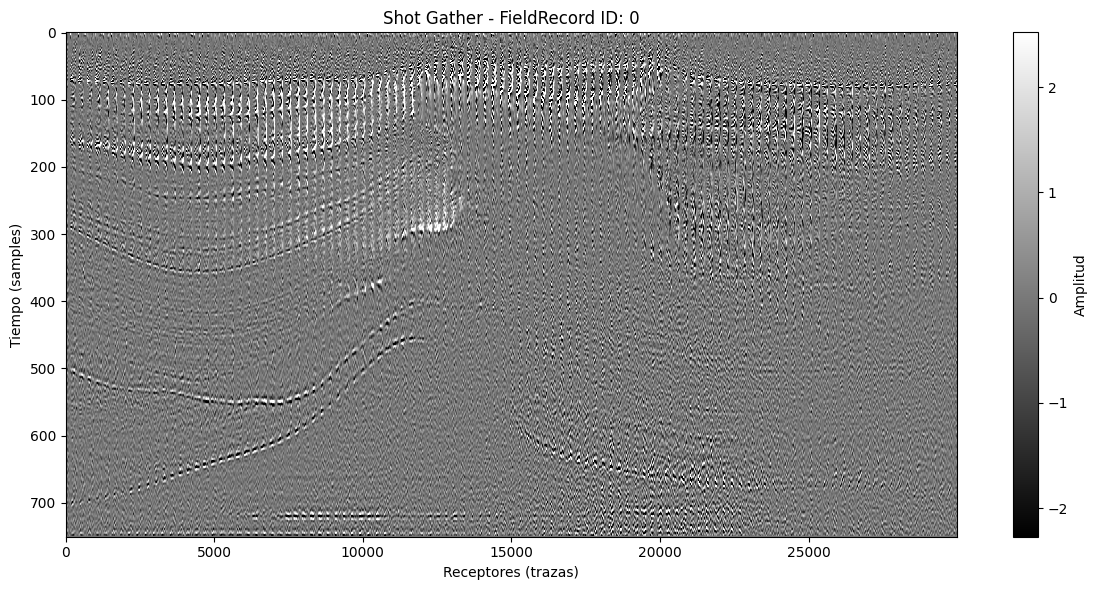

🔹 Total de patches generados: 932
🔹 Dimensiones de cada patch: (256, 256)


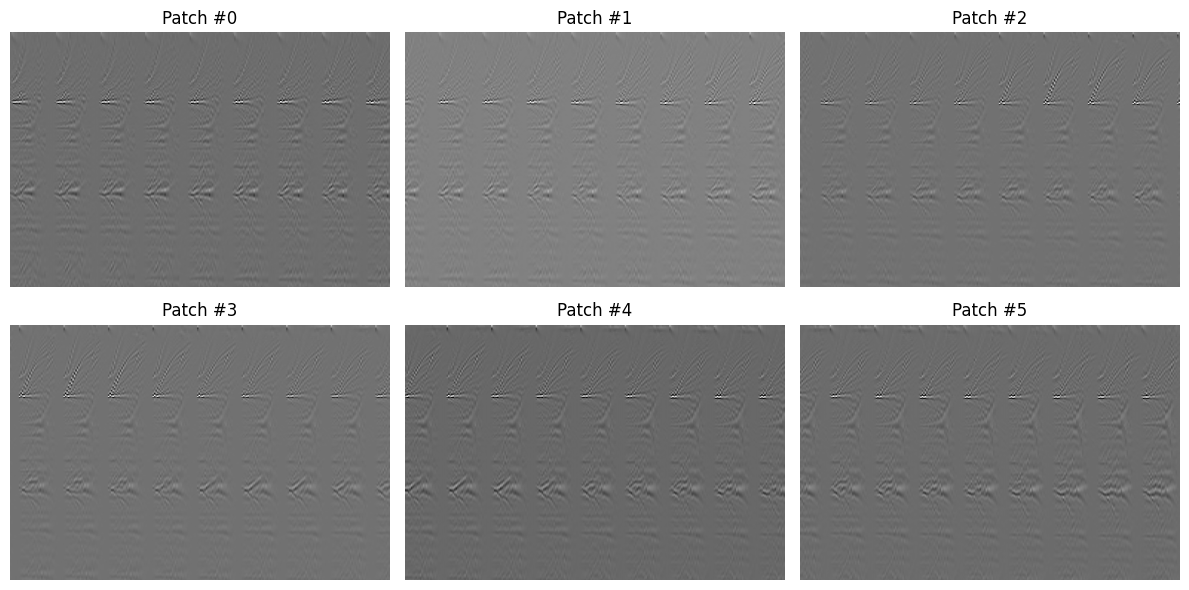

🔁 Epoch 1/10 - Loss: 79.2549
🔁 Epoch 2/10 - Loss: 66.9318
🔁 Epoch 3/10 - Loss: 62.7925
🔁 Epoch 4/10 - Loss: 61.8351
🔁 Epoch 5/10 - Loss: 60.0009
🔁 Epoch 6/10 - Loss: 59.1545
🔁 Epoch 7/10 - Loss: 58.5915
🔁 Epoch 8/10 - Loss: 57.0632
🔁 Epoch 9/10 - Loss: 55.2054
🔁 Epoch 10/10 - Loss: 52.4551


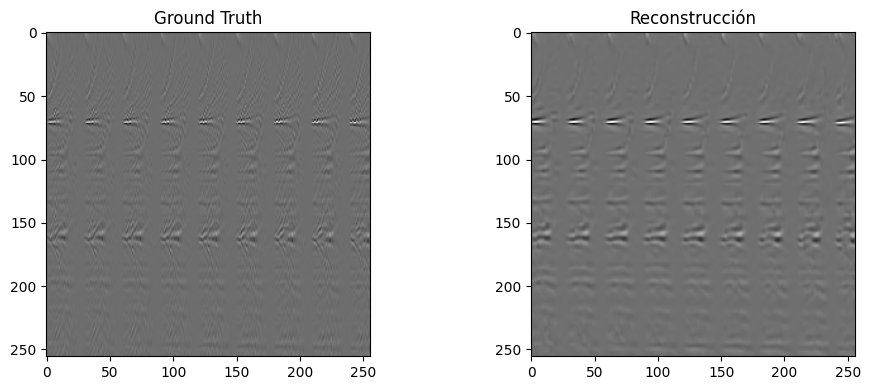

/tmp/ipykernel_8837/2730061199.py:199: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8837/2730061199.py:199: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


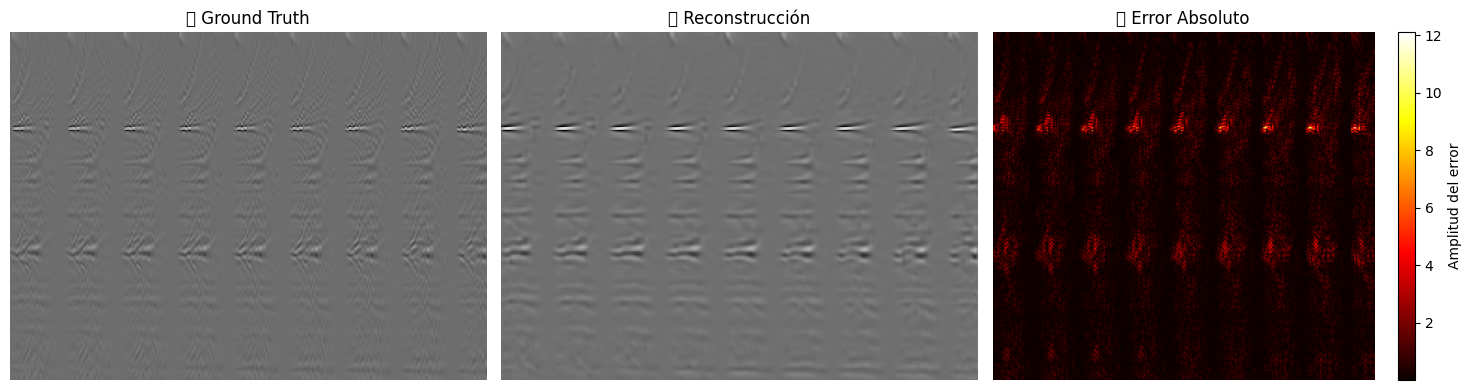

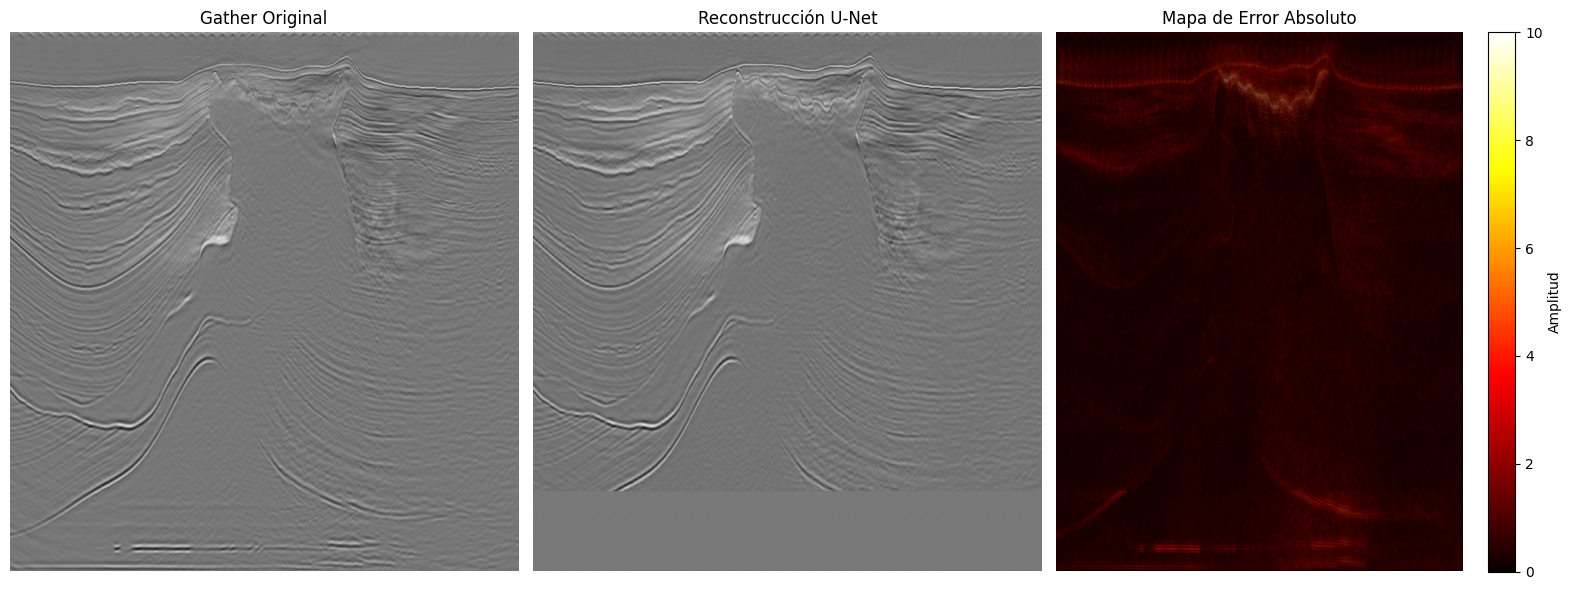

📊 Métricas finales de reconstrucción sobre todo el gather:
🔸 MSE  = 0.456593
🔸 MAE  = 0.394677
🔸 PSNR = 43.70 dB
🔸 SSIM = 0.9749


In [ ]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
from math import log10

filename = "/home/pc-2/Documents/CAVE_minciencias/SEAM_Interpretation_Challenge_1_Depth/SEAM_Interpretation_Challenge_1_2DGathers_Depth.sgy"

with segyio.open(filename, "r", ignore_geometry=True) as f:
    f.mmap()

    n_trazas = f.tracecount
    n_muestras = len(f.samples)
    muestra_dt = f.bin[segyio.BinField.Interval] / 1000  

    gather_ids = f.attributes(segyio.TraceField.FieldRecord)[:]
    ids_unicos = np.unique(gather_ids)

print(f"🔹 Trazas totales: {n_trazas}")
print(f"🔹 Muestras por traza: {n_muestras}")
print(f"🔹 Intervalo de muestreo: {muestra_dt} ms")
print(f"🔹 Número de shot gathers (FieldRecord únicos): {len(ids_unicos)}")

gather_id = ids_unicos[0]

idxs = np.where(gather_ids == gather_id)[0]

with segyio.open(filename, "r", ignore_geometry=True) as f:
    f.mmap()
    gather = np.stack([f.trace[i] for i in idxs])
    gather = gather.T 

gather = (gather - np.mean(gather)) / np.std(gather)

vmin, vmax = np.percentile(gather, [1, 99])

plt.figure(figsize=(12, 6))
plt.imshow(gather, cmap='gray', aspect='auto', interpolation='none', vmin=vmin, vmax=vmax)
plt.title(f"Shot Gather - FieldRecord ID: {gather_id}")
plt.xlabel("Receptores (trazas)")
plt.ylabel("Tiempo (samples)")
plt.colorbar(label="Amplitud")
plt.tight_layout()
plt.show()

def extract_patches(img, patch_size=(256, 256), stride=(128, 128)):
    patches = []
    for i in range(0, img.shape[0] - patch_size[0] + 1, stride[0]):
        for j in range(0, img.shape[1] - patch_size[1] + 1, stride[1]):
            patch = img[i:i+patch_size[0], j:j+patch_size[1]]
            patches.append(patch)
    return np.array(patches)

gather_norm = (gather - np.mean(gather)) / np.std(gather)

patches = extract_patches(gather_norm, patch_size=(256, 256), stride=(128, 128))

print(f"🔹 Total de patches generados: {patches.shape[0]}")
print(f"🔹 Dimensiones de cada patch: {patches.shape[1:]}") 

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(patches[i], cmap='gray', aspect='auto')
    plt.title(f"Patch #{i}")
    plt.axis("off")
plt.tight_layout()
plt.show()

class GatherPatchesDataset(Dataset):
    def __init__(self, patches):
        self.X = torch.tensor(patches).float().unsqueeze(1) 
        self.Y = self.X.clone() 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)

        self.dec3 = CBR(256, 128)
        self.dec2 = CBR(128, 64)
        self.dec1 = nn.Conv2d(64, 1, 1)

        self.pool = nn.MaxPool2d(2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x1 = self.enc1(x)    
        x2 = self.enc2(self.pool(x1))  
        x3 = self.enc3(self.pool(x2)) 

        x = self.up3(x3)     
        x = self.dec3(x)
        x = self.up2(x)    
        x = self.dec2(x)
        x = self.dec1(x)
        return x

dataset = GatherPatchesDataset(patches)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for X, Y in dataloader:
        X, Y = X.cuda(), Y.cuda()

        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"🔁 Epoch {epoch+1}/{n_epochs} - Loss: {total_loss:.4f}")

model.eval()
with torch.no_grad():
    X_sample, Y_sample = dataset[0]
    X_input = X_sample.unsqueeze(0).cuda()
    Y_pred = model(X_input).cpu().squeeze().numpy()
    Y_true = Y_sample.squeeze().numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(Y_true, cmap='gray'); plt.title("Ground Truth")
plt.subplot(1,2,2); plt.imshow(Y_pred, cmap='gray'); plt.title("Reconstrucción")
plt.tight_layout(); plt.show()

error_map = np.abs(Y_true - Y_pred)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(Y_true, cmap='gray', aspect='auto')
plt.title("🔹 Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(Y_pred, cmap='gray', aspect='auto')
plt.title("🔹 Reconstrucción")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(error_map, cmap='hot', aspect='auto')
plt.title("🔸 Error Absoluto")
plt.colorbar(label="Amplitud del error")
plt.axis("off")

plt.tight_layout()
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

patch_preds = []

for X, _ in dataset:
    with torch.no_grad():
        X_input = X.unsqueeze(0).to(device) 
        Y_hat = model(X_input).squeeze().cpu().numpy() 
        patch_preds.append(Y_hat)

def reassemble_from_patches(patch_preds, output_shape, patch_size=(256, 256), stride=(128, 128)):
    recon = np.zeros(output_shape)
    weight = np.zeros(output_shape)

    idx = 0
    for i in range(0, output_shape[0] - patch_size[0] + 1, stride[0]):
        for j in range(0, output_shape[1] - patch_size[1] + 1, stride[1]):
            recon[i:i+patch_size[0], j:j+patch_size[1]] += patch_preds[idx]
            weight[i:i+patch_size[0], j:j+patch_size[1]] += 1
            idx += 1

    weight[weight == 0] = 1
    return recon / weight

recon_gather = reassemble_from_patches(
    patch_preds,
    output_shape=gather.shape,
    patch_size=(256, 256),
    stride=(128, 128)
)

recorte = slice(None), slice(0, 30000) 

original = gather[recorte]
reconstruido = recon_gather[recorte]
error_map = np.abs(original - reconstruido)

vmin, vmax = np.percentile(original, [1, 99])

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.imshow(original, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.title("Gather Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(reconstruido, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.title("Reconstrucción U-Net")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(error_map, cmap='hot', aspect='auto', vmin=0, vmax=10)
plt.title("Mapa de Error Absoluto")
plt.colorbar(label="Amplitud")
plt.axis("off")

plt.tight_layout()
plt.show()

original = gather
reconstruido = recon_gather

mse = np.mean((original - reconstruido)**2)

mae = np.mean(np.abs(original - reconstruido))

psnr = 20 * log10(np.max(original) / np.sqrt(mse))

orig_norm = (original - original.min()) / (original.max() - original.min())
recon_norm = (reconstruido - reconstruido.min()) / (reconstruido.max() - reconstruido.min())
ssim_val = ssim(orig_norm, recon_norm, data_range=1.0)

print("📊 Métricas finales de reconstrucción sobre todo el gather:")
print(f"🔸 MSE  = {mse:.6f}")
print(f"🔸 MAE  = {mae:.6f}")
print(f"🔸 PSNR = {psnr:.2f} dB")
print(f"🔸 SSIM = {ssim_val:.4f}")

# Modelo Train/Test

In [ ]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from math import log10
import matplotlib.pyplot as plt

filename = "/home/pc-2/Documents/CAVE_minciencias/SEAM_Interpretation_Challenge_1_Depth/SEAM_Interpretation_Challenge_1_2DGathers_Depth.sgy"
with segyio.open(filename, "r", ignore_geometry=True) as f:
    f.mmap()
    gather_ids = f.attributes(segyio.TraceField.FieldRecord)[:]
    idxs = np.where(gather_ids == gather_ids[0])[0]
    gather = np.stack([f.trace[i] for i in idxs]).T

gather = (gather - np.mean(gather)) / np.std(gather)

def extract_patches(img, patch_size=(256, 256), stride=(128, 128)):
    patches = []
    for i in range(0, img.shape[0] - patch_size[0] + 1, stride[0]):
        for j in range(0, img.shape[1] - patch_size[1] + 1, stride[1]):
            patches.append(img[i:i+patch_size[0], j:j+patch_size[1]])
    return np.array(patches)

patches = extract_patches(gather, patch_size=(256, 256), stride=(128, 128))

train_patches, test_patches = train_test_split(patches, test_size=0.2, random_state=42)

class GatherPatchesDataset(Dataset):
    def __init__(self, patches):
        self.X = torch.tensor(patches).float().unsqueeze(1)
        self.Y = self.X.clone()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = GatherPatchesDataset(train_patches)
test_dataset = GatherPatchesDataset(test_patches)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True))
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = CBR(256, 128)
        self.dec2 = CBR(128, 64)
        self.dec1 = nn.Conv2d(64, 1, 1)
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x = self.up3(x3)
        x = self.dec3(x)
        x = self.up2(x)
        x = self.dec2(x)
        x = self.dec1(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        loss = loss_fn(model(X), Y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

model.eval()
mse_total, mae_total, psnr_total, ssim_total = 0, 0, 0, 0
n = 0

with torch.no_grad():
    for X, Y in test_loader:
        X = X.to(device)
        Y_hat = model(X).cpu().numpy()
        Y_true = Y.numpy()
        for i in range(len(Y_true)):
            pred = Y_hat[i, 0]
            true = Y_true[i, 0]
            mse = np.mean((pred - true)**2)
            mae = np.mean(np.abs(pred - true))
            psnr = 20 * log10(np.max(true) / np.sqrt(mse))
            ssim_val = ssim((true - true.min())/(true.max()-true.min()),
                            (pred - pred.min())/(pred.max()-pred.min()),
                            data_range=1.0)
            mse_total += mse
            mae_total += mae
            psnr_total += psnr
            ssim_total += ssim_val
            n += 1

print("\n📊 Métricas promedio en TEST:")
print(f"🔸 MSE  = {mse_total/n:.6f}")
print(f"🔸 MAE  = {mae_total/n:.6f}")
print(f"🔸 PSNR = {psnr_total/n:.2f} dB")
print(f"🔸 SSIM = {ssim_total/n:.4f}")

model.eval()
n_visualizaciones = 5  

with torch.no_grad():
    muestras = 0
    for X, Y in test_loader:
        X = X.to(device)
        Y_hat = model(X).cpu().numpy()
        Y_true = Y.numpy()

        for i in range(len(Y_true)):
            if muestras >= n_visualizaciones:
                break

            gt = Y_true[i, 0]
            pred = Y_hat[i, 0]
            error = np.abs(gt - pred)

            vmin, vmax = np.percentile(gt, [1, 99])

            plt.figure(figsize=(15, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(gt, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
            plt.title("🔹 Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
            plt.title("🔹 Reconstrucción")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(error, cmap='hot', aspect='auto')
            plt.title("🔸 Error Absoluto")
            plt.colorbar(label="Amplitud")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            muestras += 1
        if muestras >= n_visualizaciones:
            break

all_dataset = GatherPatchesDataset(patches)
all_loader = DataLoader(all_dataset, batch_size=1)

patch_preds = []

model.eval()
with torch.no_grad():
    for X, _ in all_loader:
        X = X.to(device)
        Y_hat = model(X).cpu().squeeze().numpy()
        patch_preds.append(Y_hat)

def reassemble_from_patches(patch_preds, output_shape, patch_size=(256, 256), stride=(128, 128)):
    recon = np.zeros(output_shape)
    weight = np.zeros(output_shape)

    idx = 0
    for i in range(0, output_shape[0] - patch_size[0] + 1, stride[0]):
        for j in range(0, output_shape[1] - patch_size[1] + 1, stride[1]):
            recon[i:i+patch_size[0], j:j+patch_size[1]] += patch_preds[idx]
            weight[i:i+patch_size[0], j:j+patch_size[1]] += 1
            idx += 1

    weight[weight == 0] = 1
    return recon / weight

recon_gather = reassemble_from_patches(
    patch_preds,
    output_shape=gather.shape,
    patch_size=(256, 256),
    stride=(128, 128)
)

error_map = np.abs(gather - recon_gather)

vmin, vmax = np.percentile(gather, [1, 99])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(gather, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.title("🔹 Gather Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(recon_gather, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.title("🔹 Reconstrucción Completa")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(error_map, cmap='hot', aspect='auto', vmin=0, vmax=10)
plt.title("🔸 Mapa de Error Absoluto")
plt.colorbar(label="Amplitud del Error")
plt.axis("off")

plt.tight_layout()
plt.show()

Epoch 1 - Loss: 65.8884
Epoch 2 - Loss: 55.8584
Epoch 3 - Loss: 52.6942
Epoch 4 - Loss: 51.5434
Epoch 5 - Loss: 49.8181
Epoch 6 - Loss: 49.7697
Epoch 7 - Loss: 48.5818
Epoch 8 - Loss: 49.0451
Epoch 9 - Loss: 47.3036
Epoch 10 - Loss: 48.2389

📊 Métricas promedio en TEST:
🔸 MSE  = 0.457305
🔸 MAE  = 0.394729
🔸 PSNR = 20.52 dB
🔸 SSIM = 0.5821
